In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMakerPlus import *

2023-05-14 16:10:53.720451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 16:10:54.623154: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-14 16:10:54.623205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-14 16:10:54.623210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 256
EPOCHS = 100
GB_LIMIT = 10
Z_MAX = 4
LR = 0.0001

hparams = {
    'batch_size': BATCH_SIZE,
    'num_epochs': EPOCHS,
    'z_max': Z_MAX,
    'learning_rate': LR
}

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
args_gen = {'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': True,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}

TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5'
VAL_PATH = f'/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing.hdf5'

In [5]:
train_gen = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen = HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

In [6]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [7]:
input_ = Input(shape=(5,127,127))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(input_)
pool1 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool2)
pool3 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv3)
conv4 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool3)
pool4 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv4)
conv5 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool4)
pool5 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv5)
conv6 = Conv2D(512, kernel_size=(3, 3),activation='relu', padding='same', data_format='channels_first')(pool5)
conv7 = Conv2D(512, kernel_size=(3, 3),activation='relu', padding='same', data_format='channels_first')(conv6)
flatten = Flatten()(conv7)
dense1 = Dense(512, activation='tanh')(flatten)
dense2 = Dense(128, activation='tanh')(dense1)
dense3 = Dense(32, activation='tanh')(dense2)
output = Dense(1)(dense3)
model = Model(inputs=[input_], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 127, 127)]     0         
                                                                 
 conv2d (Conv2D)             (None, 32, 127, 127)      1472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 63, 63)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 63, 63)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 31, 31)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 31, 31)       73856 

In [8]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

In [9]:
model_name = 'HSC_v6_CNN5pool_v4'

checkpoint_filepath = f'/data2/models/{model_name}/checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
log_dir = os.path.join('/data2/logs/', model_name)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
    verbose=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hparam_callback = hp.KerasCallback(log_dir, hparams)

In [10]:
model.fit(train_gen, epochs=EPOCHS, shuffle=True, verbose=1, validation_data=val_gen, callbacks=[tensorboard_callback, model_checkpoint_callback, hparam_callback])

Epoch 1/100
784/784 [==============================] - ETA: 0s - loss: 0.2515 - mse: 0.2626
Epoch 1: loss improved from inf to 0.25147, saving model to /data2/models/HSC_v6_CNN5pool_v4/checkpoints/cp.ckpt
784/784 [==============================] - 659s 834ms/step - loss: 0.2515 - mse: 0.2626 - val_loss: 0.1976 - val_mse: 0.1405
Epoch 2/100
784/784 [==============================] - ETA: 0s - loss: 0.1789 - mse: 0.1187
Epoch 2: loss improved from 0.25147 to 0.17889, saving model to /data2/models/HSC_v6_CNN5pool_v4/checkpoints/cp.ckpt
784/784 [==============================] - 537s 685ms/step - loss: 0.1789 - mse: 0.1187 - val_loss: 0.1558 - val_mse: 0.1074
Epoch 3/100
784/784 [==============================] - ETA: 0s - loss: 0.1461 - mse: 0.1080
Epoch 3: loss improved from 0.17889 to 0.14607, saving model to /data2/models/HSC_v6_CNN5pool_v4/checkpoints/cp.ckpt
784/784 [==============================] - 674s 860ms/step - loss: 0.1461 - mse: 0.1080 - val_loss: 0.1448 - val_mse: 0.1031
Ep

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - ETA: 0s - loss: 0.0336 - mse: 0.0446
Epoch 73: loss did not improve from 0.03064
784/784 [==============================] - 760s 969ms/step - loss: 0.0336 - mse: 0.0446 - val_loss: 0.0579 - val_mse: 0.0547
Epoch 74/100
784/784 [==============================] - ETA: 0s - loss: 0.0312 - mse: 0.0371
Epoch 74: loss did not improve from 0.03064
784/784 [==============================] - 796s 1s/step - loss: 0.0312 - mse: 0.0371 - val_loss: 0.0579 - val_mse: 0.0543
Epoch 75/100
784/784 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0358
Epoch 75: loss improved from 0.03064 to 0.03001, saving model to /data2/models/HSC_v6_CNN5pool_v4/checkpoints/cp.ckpt
784/784 [==============================] - 821s 1s/step - loss: 0.0300 - mse: 0.0358 - val_loss: 0.0581 - val_mse: 0.0519
Epoch 76/100
784/784 [==============================] - ETA: 0s - loss: 0.0288 - mse: 0.0345
Epoch 76: loss improved from 0.03001 to 0.02882, saving model to /

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - ETA: 0s - loss: 0.0258 - mse: 0.0326
Epoch 89: loss did not improve from 0.02499
784/784 [==============================] - 646s 823ms/step - loss: 0.0258 - mse: 0.0326 - val_loss: 0.0587 - val_mse: 0.0513
Epoch 90/100
784/784 [==============================] - ETA: 0s - loss: 0.0251 - mse: 0.0325
Epoch 90: loss did not improve from 0.02499
784/784 [==============================] - 609s 777ms/step - loss: 0.0251 - mse: 0.0325 - val_loss: 0.0588 - val_mse: 0.0526
Epoch 91/100
784/784 [==============================] - ETA: 0s - loss: 0.0263 - mse: 0.0327
Epoch 91: loss did not improve from 0.02499
784/784 [==============================] - 628s 801ms/step - loss: 0.0263 - mse: 0.0327 - val_loss: 0.0614 - val_mse: 0.0556
Epoch 92/100
784/784 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0302
Epoch 92: loss improved from 0.02499 to 0.02283, saving model to /data2/models/HSC_v6_CNN5pool_v4/checkpoints/cp.ckpt
784/784 [=======

In [11]:
model.load_weights(checkpoint_filepath)

In [12]:
pred = model.predict(test_gen)

168/168 [==============================] - 111s 659ms/step


In [13]:
with h5py.File(TEST_PATH, 'r') as file:
    y_test = np.asarray(file['specz_redshift'][:])
    oid_test = np.asarray(file['object_id'][:])

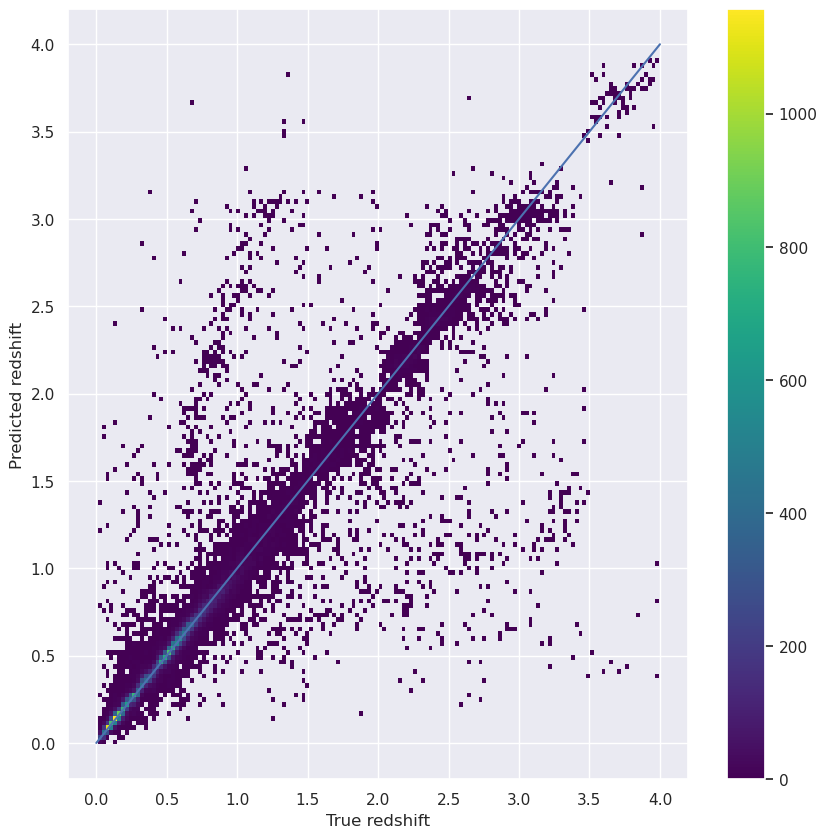

In [14]:
plot_predictions(np.ravel(pred), y_test)

In [15]:
metrics = get_point_metrics(pd.Series(np.ravel(pred)), pd.Series(y_test), binned=False)

In [16]:
metrics

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",42960,0.056821,0.002055,0.0024,0.020513,0.017445,0.137803,0.036778,0.048397


In [17]:
df = pd.DataFrame(pred, columns=['photoz'])
df['specz'] = pd.Series(y_test)
df['object_id'] = pd.Series(oid_test)
os.makedirs(f'/data2/predictions/{model_name}', exist_ok=True)
df.to_csv(f'/data2/predictions/{model_name}/testing_predictions.csv', index=False)
metrics.to_csv(f'/data2/predictions/{model_name}/testing_metrics.csv', index=False)